In [1]:
import pandas as pd
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load the data

In [2]:
csvs = os.listdir('accepted/')

In [3]:
# make sure all csv files have the same headers
with open("accepted/"+csvs[0], 'r') as f:
    columns = f.readlines()[0]
for c in csvs[1:]:
    with open("accepted/" + c, 'r') as f:
        if f.readlines()[0] != columns:
            print(c)

In [4]:
dtype = {'id':str,'member_id':str,'loan_amnt':float,'funded_amnt':float,'funded_amnt_inv':float,
         'term':str,'int_rate':str,
         'installment':float,'grade':str,'sub_grade':str,'emp_title':str,'emp_length':str,'home_ownership':str,
         'annual_inc':float,'verification_status':str,'issue_d':str,'loan_status':str,'pymnt_plan':str,'url':str,
         'desc':str,'purpose':str,'title':str,'zip_code':str,'addr_state':str,'dti':float,'delinq_2yrs':float,
         'earliest_cr_line':str,'inq_last_6mths':float,'mths_since_last_delinq':float,
         'mths_since_last_record':float,
         'open_acc':float,'pub_rec':float,'revol_bal':float,'total_acc':float,'initial_list_status':str,
         'out_prncp':float,
         'out_prncp_inv':float,'total_pymnt':float,'total_pymnt_inv':float,'total_rec_prncp':float,
         'total_rec_int':float,
         'total_rec_late_fee':float,'recoveries':float,'collection_recovery_fee':float,'last_pymnt_d':str,
         'last_pymnt_amnt':float,'next_pymnt_d':str,'last_credit_pull_d':str,'collections_12_mths_ex_med':float,
         'mths_since_last_major_derog':float,'policy_code':str,'application_type':str,'annual_inc_joint':float,
         'dti_joint':float,'verification_status_joint':str,'acc_now_delinq':float,'tot_coll_amt':float,
         'tot_cur_bal':float,
         'open_acc_6m':float,'open_act_il':float,'open_il_12m':float,'open_il_24m':float,
         'mths_since_rcnt_il':float,'total_bal_il':float,
         'il_util':str,'open_rv_12m':float,'open_rv_24m':float,'max_bal_bc':float,'all_util':float,
         'total_rev_hi_lim':float,
         'inq_fi':float,'total_cu_tl':float,'inq_last_12m':float,'acc_open_past_24mths':float,'avg_cur_bal':float,
         'bc_open_to_buy':str,'bc_util':str,'chargeoff_within_12_mths':float,'delinq_amnt':float,
         'mo_sin_old_il_acct':str,
         'mo_sin_old_rev_tl_op':str,'mo_sin_rcnt_rev_tl_op':str,'mo_sin_rcnt_tl':str,'mort_acc':float,
         'mths_since_recent_bc':float,'mths_since_recent_bc_dlq':float,'mths_since_recent_inq':float,
         'mths_since_recent_revol_delinq':float,
         'num_accts_ever_120_pd':float,'num_actv_bc_tl':float,'num_actv_rev_tl':float,'num_bc_sats':float,
         'num_bc_tl':float,
         'num_il_tl':float,'num_op_rev_tl':float,'num_rev_accts':float,'num_rev_tl_bal_gt_0':float,'num_sats':float,
         'num_tl_120dpd_2m':float,'num_tl_30dpd':float,'num_tl_90g_dpd_24m':float,'num_tl_op_past_12m':float,
         'pct_tl_nvr_dlq':float,'percent_bc_gt_75':float,'pub_rec_bankruptcies':float,'tax_liens':float,
         'tot_hi_cred_lim':float,
         'total_bal_ex_mort':float,'total_bc_limit':float,'total_il_high_credit_limit':float,'revol_bal_joint':float,
         'sec_app_earliest_cr_line':str,'sec_app_inq_last_6mths':float,'sec_app_mort_acc':str,'sec_app_open_acc':str,
         'sec_app_revol_util':str,'sec_app_open_act_il':str,'sec_app_num_rev_accts':float,
         'sec_app_chargeoff_within_12_mths':float,
         'sec_app_collections_12_mths_ex_med':float,'sec_app_mths_since_last_major_derog':float,'hardship_flag':str,
         'hardship_type':str,'hardship_reason':str,'hardship_status':str,'deferral_term':str,'hardship_amount':float,
         'hardship_start_date':str,'hardship_end_date':str,'payment_plan_start_date':str,'hardship_length':str,
         'hardship_dpd':float,'hardship_loan_status':str,'orig_projected_additional_accrued_interest':float,
         'hardship_payoff_balance_amount':float,'hardship_last_payment_amount':float,'disbursement_method':str,
         'debt_settlement_flag':str,'debt_settlement_flag_date':str,'settlement_status':str,'settlement_date':str,
         'settlement_amount':float,'settlement_percentage':float,'settlement_term':str}

In [5]:
df = pd.DataFrame(columns=dtype.keys())
for i,c in enumerate(csvs):
    df = df.append(pd.read_csv("accepted/" + c, dtype=dtype))

In [6]:
print("number of data points: {}".format(len(df)))

number of data points: 1765451


### Drop current and unlabeled borrowers

In [7]:
print(df.loan_status.value_counts(normalize=True))

Current                                                0.523060
Fully Paid                                             0.357402
Charged Off                                            0.091091
Late (31-120 days)                                     0.014585
In Grace Period                                        0.009283
Late (16-30 days)                                      0.002981
Does not meet the credit policy. Status:Fully Paid     0.001126
Does not meet the credit policy. Status:Charged Off    0.000431
Default                                                0.000041
Name: loan_status, dtype: float64


We drop current borrowers, as we are primarily interested in those who have already paid off or charged off on their loans. We save the current borrowers to predict how they will behave for future projects. Note that "Charged Off" means no further payment is expected. This typically occurs when a payment is 150+ days past due. "Default" typically means the borrower has not made a payment for 121+ days, but the account has not been closed or sent to collections yet (see https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-).

The labels that include "Does not meet the credit policy" means those applicants would not be awarded a loan under Lending Club's current policy. We omit them from this analysis, as we are concerned with the current policy of Lending Club.

In [8]:
# save current borrowers for separate analysis
current_df = df[(df.loan_status != 'Fully Paid') & (df.loan_status != 'Charged Off') 
                & (df.loan_status != 'Does not meet the credit policy. Status:Fully Paid')
                & (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [9]:
current_df.to_csv("data/current_borrowers.csv", index=False)

We drop the unlabeled data points, as the proportion of unlabeled points (about .003%) is marginal.

In [10]:
print("number of unlabeled points: {}".format(len(df) - df.loan_status.value_counts().sum()))

number of unlabeled points: 25


In [11]:
# drop unlabeled data points (nan)
df = df.dropna(subset=['loan_status'])
len(df)

1765426

In [12]:
unqualified_df = df[df.loan_status.str.contains("Does not meet the credit policy")]
len(unqualified_df)

2749

In [13]:
# save those who don't meet the policy today in a separate csv
unqualified_df.to_csv("data/unqualified_df.csv", index=False)
df = df[(df.loan_status != 'Does not meet the credit policy. Status:Fully Paid') & 
        (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]
len(df)

1762677

In [14]:
# drop current borrowers
df = df[df.loan_status!='Current']
df = df[df.loan_status!='In Grace Period']
df = df[df.loan_status!='Late (31-120 days)']
df = df[df.loan_status!='Late (16-30 days)']
df = df[df.loan_status!='Default']

In [15]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off']


In [16]:
df.loan_status.value_counts(normalize=True)

Fully Paid     0.796896
Charged Off    0.203104
Name: loan_status, dtype: float64

Observations labeled with "Does not meet the credit policy" are people that borrowed from Lending Club in the past, but would not currently qualify for a loan under Lending Club's current policy. We save them as a separate dataframe for further analysis; perhaps we can identify the change in Lending Club's policy that would cause those borrowers to not qualify for a loan today.

### Label the data

In [17]:
df.loan_status = df.loan_status.map({'Fully Paid':1, 'Charged Off':0})
df.to_csv('data/labeled.csv', index=False)

In [18]:
# change loan_status to int, due to encoded labels
dtype['loan_status'] = int
df = pd.read_csv('data/labeled.csv', dtype=dtype)
len(df.columns)

145

### Remove features that are not available for new applicants

Since we want to this analysis to be useful for new applicants, we drop the columns that are available for only those whose applications have been accepted and have already received the loan for which they applied. Many of these features have to do with payment schedules, recovery fees, and hardship plans.

In [18]:
feats = ['collection_recovery_fee', 'funded_amnt', 'funded_amnt_inv', 'issue_d', 'last_credit_pull_d',
         'last_pymnt_amnt', 'last_pymnt_d', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'pymnt_plan',
         'recoveries', 'term', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
         'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
         'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
         'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
         'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 
         'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
         'settlement_amount', 'settlement_percentage', 'settlement_term']
df.drop(feats, axis=1, inplace=True)

### Remove uniform columns

In [19]:
# find features with uniform values
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col, len(df[col].unique()))
        df.drop(col, axis=1, inplace=True)

id 1
member_id 1
policy_code 1
url 1


In [20]:
df.shape

(791781, 100)

### Remove nearly uniform columns (99% or more one value)

In [21]:
df.application_type.value_counts(normalize=True)

Individual    0.995332
Joint App     0.004668
Name: application_type, dtype: float64

In [22]:
df.drop('application_type', axis=1, inplace=True)

In [23]:
df.num_tl_120dpd_2m.value_counts(normalize=True)

0.0    0.999187
1.0    0.000779
2.0    0.000029
3.0    0.000004
6.0    0.000001
Name: num_tl_120dpd_2m, dtype: float64

In [24]:
df.drop('num_tl_120dpd_2m', axis=1, inplace=True)

In [25]:
df.num_tl_30dpd.value_counts(normalize=True)

0.0    0.996822
1.0    0.003021
2.0    0.000130
3.0    0.000021
4.0    0.000007
Name: num_tl_30dpd, dtype: float64

In [26]:
df.drop('num_tl_30dpd', axis=1, inplace=True)

In [27]:
df.num_tl_90g_dpd_24m.value_counts(normalize=True).iloc[:10]

0.0    0.943032
1.0    0.042586
2.0    0.008732
3.0    0.002325
4.0    0.001283
5.0    0.000639
6.0    0.000453
7.0    0.000279
8.0    0.000186
9.0    0.000135
Name: num_tl_90g_dpd_24m, dtype: float64

In [28]:
df.drop('num_tl_90g_dpd_24m', axis=1, inplace=True)

In [29]:
df.chargeoff_within_12_mths.value_counts(normalize=True).iloc[:10]

0.0     0.992371
1.0     0.006899
2.0     0.000595
3.0     0.000091
4.0     0.000025
5.0     0.000009
7.0     0.000004
6.0     0.000004
8.0     0.000001
10.0    0.000001
Name: chargeoff_within_12_mths, dtype: float64

In [30]:
df.drop('chargeoff_within_12_mths', axis=1, inplace=True)

In [31]:
df.collections_12_mths_ex_med.value_counts(normalize=True).iloc[:10]

0.0     0.986950
1.0     0.012137
2.0     0.000782
3.0     0.000082
4.0     0.000028
6.0     0.000008
5.0     0.000006
12.0    0.000003
7.0     0.000001
20.0    0.000001
Name: collections_12_mths_ex_med, dtype: float64

In [32]:
df.drop('collections_12_mths_ex_med', axis=1, inplace=True)

In [33]:
df.tax_liens.value_counts(normalize=True).iloc[:10]

0.0    0.971738
1.0    0.019566
2.0    0.005166
3.0    0.001782
4.0    0.000802
5.0    0.000416
6.0    0.000227
7.0    0.000111
8.0    0.000054
9.0    0.000043
Name: tax_liens, dtype: float64

In [34]:
df.drop('tax_liens', axis=1, inplace=True)

In [35]:
df.acc_now_delinq.value_counts(normalize=True)

0.0    0.995499
1.0    0.004247
2.0    0.000215
3.0    0.000027
4.0    0.000009
5.0    0.000003
6.0    0.000001
Name: acc_now_delinq, dtype: float64

In [36]:
df.drop('acc_now_delinq', axis=1, inplace=True)

### Remove columns with a majority (70% or more) of missing values

In [37]:
null_counts = dict(df.isnull().sum())
null_cols = []
for key,val in null_counts.items():
    if val/df.shape[0] >= .7:
        print("{:<35}\t{}".format((key), val/df.shape[0]))
    if val/df.shape[0] >= 0.7:
        null_cols.append(key)

all_util                           	0.7903877461065623
annual_inc_joint                   	0.995332042572378
desc                               	0.8491161066001837
dti_joint                          	0.995332042572378
il_util                            	0.8168483456915485
inq_fi                             	0.790373853376123
inq_last_12m                       	0.7903751163516174
max_bal_bc                         	0.790373853376123
mths_since_last_major_derog        	0.7493372536092682
mths_since_last_record             	0.8365583412585046
mths_since_rcnt_il                 	0.7950165512938553
mths_since_recent_bc_dlq           	0.7683803981151354
open_acc_6m                        	0.7903751163516174
open_act_il                        	0.790373853376123
open_il_12m                        	0.790373853376123
open_il_24m                        	0.790373853376123
open_rv_12m                        	0.790373853376123
open_rv_24m                        	0.790373853376123
revol_bal_joint    

In [38]:
print(len(null_cols))
df.drop(null_cols, axis=1, inplace=True)
print(len(df.columns))

32
60


### Drop columns that aren't helpful or are strongly correlated with other features

In [39]:
df['zip_code'].head()

0     775xx
1     985xx
9     333xx
11    770xx
15    760xx
Name: zip_code, dtype: object

In [40]:
# drop the zip_code feature, since we can't work with 3-digit zip codes, and addr_state gives the state
df.drop("zip_code", axis=1, inplace=True)

In [41]:
df.drop('addr_state', axis=1, inplace=True)

In [42]:
df['title'].head(10)

0          Debt consolidation
1          Debt consolidation
9            Home improvement
11         Debt consolidation
15         Debt consolidation
16             Major purchase
20    Credit card refinancing
25      Moving and relocation
26         Debt consolidation
29                      Other
Name: title, dtype: object

In [43]:
# make lower case
df['title'] = df['title'].str.lower()
# got rid of about 10000 categories
print(len(df['title'].unique()))
print(df['title'].isnull().sum())

50798
7387


In [44]:
# keep top x categories
# use substring matching to combine categories (other ways to combine categories)
# make new categories for leftovers
print(len(df['title'].unique()))
df['title'].value_counts(normalize=True).iloc[:15]

50798


debt consolidation           0.482650
credit card refinancing      0.163981
home improvement             0.051340
other                        0.041199
major purchase               0.015564
consolidation                0.009329
medical expenses             0.008617
business                     0.008354
car financing                0.007036
debt consolidation loan      0.005771
vacation                     0.005375
moving and relocation        0.005240
credit card consolidation    0.004281
personal loan                0.004013
home buying                  0.003573
Name: title, dtype: float64

In [45]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590490
credit_card           0.214485
home_improvement      0.062402
other                 0.054115
major_purchase        0.021540
small_business        0.012631
car                   0.011061
medical               0.010753
moving                0.007041
vacation              0.006292
house                 0.005166
wedding               0.002868
renewable_energy      0.000744
educational           0.000412
Name: purpose, dtype: float64

In [46]:
# drop title (for now), as purpose is a more uniform, consistent way to measure a similar thing (high correlation)
df.drop('title', axis=1, inplace=True)

In [47]:
df.emp_title.head()

0              Buyer
1                USA
9                NaN
11               NaN
15    member service
Name: emp_title, dtype: object

In [48]:
len(df.emp_title.unique())

275475

In [49]:
# for similar reasoning, drop emp_title (user input, very messy)
df.drop('emp_title', axis=1, inplace=True)

In [50]:
df.grade.value_counts(normalize=True)

B    0.288935
C    0.276340
A    0.163899
D    0.156993
E    0.078034
F    0.028402
G    0.007397
Name: grade, dtype: float64

In [51]:
df.sub_grade.value_counts(normalize=True)

B3    0.063241
B4    0.062870
C1    0.061520
C2    0.058502
B5    0.058317
B2    0.054934
C3    0.054861
C4    0.053442
B1    0.049573
C5    0.048016
A5    0.046678
D1    0.040097
A4    0.038796
D2    0.034604
D3    0.030087
D4    0.028502
A1    0.026889
A3    0.026525
A2    0.025011
D5    0.023704
E1    0.020006
E2    0.018178
E3    0.015271
E4    0.013143
E5    0.011438
F1    0.008730
F2    0.006488
F3    0.005491
F4    0.004294
F5    0.003399
G1    0.002464
G2    0.001841
G3    0.001321
G4    0.000976
G5    0.000794
Name: sub_grade, dtype: float64

In [52]:
df.grade = df.sub_grade.apply(lambda x: x[0] if x[0]=='E' or x[0]=='F' or x[0]=='G' else x)

In [53]:
df.grade.value_counts(normalize=True)

E     0.078034
B3    0.063241
B4    0.062870
C1    0.061520
C2    0.058502
B5    0.058317
B2    0.054934
C3    0.054861
C4    0.053442
B1    0.049573
C5    0.048016
A5    0.046678
D1    0.040097
A4    0.038796
D2    0.034604
D3    0.030087
D4    0.028502
F     0.028402
A1    0.026889
A3    0.026525
A2    0.025011
D5    0.023704
G     0.007397
Name: grade, dtype: float64

In [54]:
# drop sub_grade, as that information can be captured in our engineered grade
df.drop('sub_grade', axis=1, inplace=True)

### Clean features and change to floats/ints

In [55]:
df['revol_util'].head()

0     50.9%
1     45.6%
9     11.9%
11       5%
15    92.6%
Name: revol_util, dtype: object

In [56]:
# change revol_util to floats
df.revol_util = df.revol_util.str[:-1].astype('float')/100
df.revol_util.head()

0     0.509
1     0.456
9     0.119
11    0.050
15    0.926
Name: revol_util, dtype: float64

In [57]:
# change earliest_cr_line to year so we can easily use it
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line']).dt.year

We keep interest rate, as it is calculated based off the grade which Lending Club gives an applicant. The method of grade assignment is explained in this link: https://www.lendingclub.com/foliofn/rateDetail.action.

In [58]:
df['int_rate'].head()

0      13.99%
1      14.49%
9       5.32%
11     12.79%
15     13.99%
Name: int_rate, dtype: object

In [59]:
df.int_rate = df.int_rate.str[:-1].astype('float')/100
df.int_rate.head()

0     0.1399
1     0.1449
9     0.0532
11    0.1279
15    0.1399
Name: int_rate, dtype: float64

In [60]:
df.bc_util = df.bc_util.astype('float')

In [61]:
df.bc_util.tail(10)

118496    76.3
118517    44.4
118526    22.2
118544    70.0
118559    78.7
118575    55.6
118576    24.6
118579     NaN
118621    18.2
118632    13.1
Name: bc_util, dtype: float64

In [62]:
df.bc_open_to_buy = df.bc_open_to_buy.astype('float')

In [63]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [64]:
df.select_dtypes(include=['O']).columns

Index(['emp_length', 'grade', 'home_ownership', 'initial_list_status',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'purpose', 'verification_status'],
      dtype='object')

In [65]:
df['emp_length'].head()

0       4 years
1     10+ years
9           n/a
11          n/a
15    10+ years
Name: emp_length, dtype: object

In [66]:
df['emp_length'] = df['emp_length'].apply(lambda x: -1 if x=='n/a' else 0 if x[0]=='<' else int(x[0]))

In [67]:
df['grade'].astype('category').cat.codes.value_counts(normalize=True)

20    0.078034
7     0.063241
8     0.062870
10    0.061520
11    0.058502
9     0.058317
6     0.054934
12    0.054861
13    0.053442
5     0.049573
14    0.048016
4     0.046678
15    0.040097
3     0.038796
16    0.034604
17    0.030087
18    0.028502
21    0.028402
0     0.026889
2     0.026525
1     0.025011
19    0.023704
22    0.007397
dtype: float64

In [68]:
df['grade'] = df['grade'].astype('category').cat.codes

In [69]:
df['home_ownership'].value_counts(normalize=True)

MORTGAGE    0.499499
RENT        0.398807
OWN         0.101346
OTHER       0.000182
ANY         0.000111
NONE        0.000054
Name: home_ownership, dtype: float64

In [70]:
ownership_dict = {'MORTGAGE':0, 'RENT': 1, 'OWN': 2, 'OTHER': 3, 'ANY': 4, 'NONE': 5}
df.home_ownership = df.home_ownership.map(ownership_dict)

In [71]:
df['initial_list_status'].value_counts(normalize=True)

f    0.511563
w    0.488437
Name: initial_list_status, dtype: float64

In [72]:
df['initial_list_status'] = df['initial_list_status'].astype('category').cat.codes

In [73]:
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].astype(float)
df['mo_sin_old_rev_tol_op'] = df['mo_sin_old_rev_tl_op'].astype(float)
df['mo_sin_rcnt_rev_tl_op'] = df['mo_sin_rcnt_rev_tl_op'].astype(float)
df['mo_sin_rcnt_tl'] = df['mo_sin_rcnt_tl'].astype(float)
df['mo_sin_old_rev_tl_op'] = df['mo_sin_old_rev_tl_op'].astype(float)

In [74]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590490
credit_card           0.214485
home_improvement      0.062402
other                 0.054115
major_purchase        0.021540
small_business        0.012631
car                   0.011061
medical               0.010753
moving                0.007041
vacation              0.006292
house                 0.005166
wedding               0.002868
renewable_energy      0.000744
educational           0.000412
Name: purpose, dtype: float64

In [75]:
df['purpose'].astype('category').cat.codes.value_counts(normalize=True)

2     0.590490
1     0.214485
4     0.062402
9     0.054115
6     0.021540
11    0.012631
0     0.011061
7     0.010753
8     0.007041
12    0.006292
5     0.005166
13    0.002868
10    0.000744
3     0.000412
dtype: float64

In [76]:
df['purpose'] = df['purpose'].astype('category').cat.codes

In [77]:
df['verification_status'].value_counts(normalize=True)

Source Verified    0.359320
Verified           0.331655
Not Verified       0.309025
Name: verification_status, dtype: float64

In [78]:
df['verification_status'] = df['verification_status'].astype('category').cat.codes

In [79]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('int8')], dtype=object)

In [80]:
print(df.columns[df.isnull().any()], len(df.columns[df.isnull().any()]))

Index(['acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'dti', 'inq_last_6mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'revol_util', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'total_rev_hi_lim',
       'mo_sin_old_rev_tol_op'],
      dtype='object') 38


In [81]:
# save the work we've done thus far
df.to_csv("data/cleaned_features.csv", index=False)

### Create train/test split and fill missing values

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), 
                                                    df['loan_status'], test_size=.25)

In [83]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((593835, 55), (593835,), (197946, 55), (197946,))

In [84]:
def describe_missing(var):
    print(X_train[var].isnull().sum()/X_train.shape[0])
    print(X_train[var].describe())
    print(y_train[X_train[var].isnull()].value_counts(normalize=True))
    X_train[var].hist(bins=15, normed=True)
    plt.show()

#### `mths_since_recent_revol_delinq`

In [85]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_revol_delinq'

0.67527343454
count    192834.000000
mean         36.220832
std          22.461038
min           0.000000
25%          17.000000
50%          33.000000
75%          53.000000
max         180.000000
Name: mths_since_recent_revol_delinq, dtype: float64
1    0.800996
0    0.199004
Name: loan_status, dtype: float64


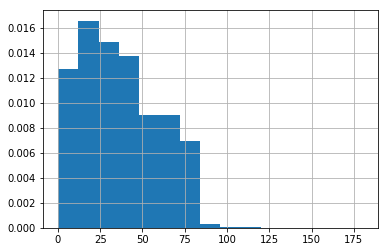

In [86]:
describe_missing('mths_since_recent_revol_delinq')

We fill missing values in `mth_since_recent_revol_delinq` with the rounded mean, as all the values are integers.

In [87]:
X_test['mths_since_recent_revol_delinq'].fillna(np.round(X_train['mths_since_recent_revol_delinq'].mean()), inplace=True)
X_train['mths_since_recent_revol_delinq'].fillna(np.round(X_train['mths_since_recent_revol_delinq'].mean()), inplace=True)

#### `mths_since_last_delinq`

In [88]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_last_delinq'

0.513152643411
count    289107.000000
mean         34.523042
std          21.940684
min           0.000000
25%          16.000000
50%          31.000000
75%          50.000000
max         188.000000
Name: mths_since_last_delinq, dtype: float64
1    0.803973
0    0.196027
Name: loan_status, dtype: float64


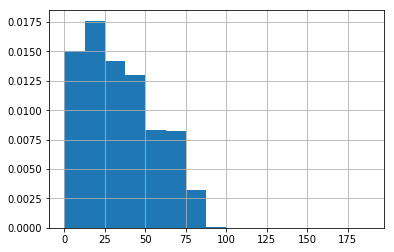

In [89]:
describe_missing('mths_since_last_delinq')

Similarly, we fill missing values in `mth_since_last_delinq` with the rounded mean, as all the values are integers.

In [90]:
X_test['mths_since_last_delinq'].fillna(np.round(X_train['mths_since_last_delinq'].mean()), inplace=True)
X_train['mths_since_last_delinq'].fillna(np.round(X_train['mths_since_last_delinq'].mean()), inplace=True)

#### `mths_since_recent_inq`

In [91]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_inq'

0.146092769877
count    507080.000000
mean          6.599408
std           5.801149
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          25.000000
Name: mths_since_recent_inq, dtype: float64
1    0.84779
0    0.15221
Name: loan_status, dtype: float64


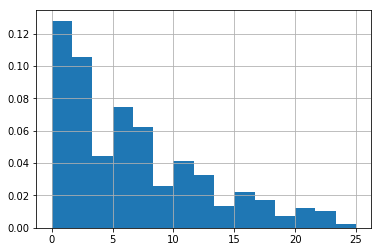

In [92]:
describe_missing('mths_since_recent_inq')

Similarly, we fill missing values in `mth_since_recent_inq` with the rounded mean, as all the values are integers.

In [93]:
X_test['mths_since_recent_inq'].fillna(np.round(X_train['mths_since_recent_inq'].mean()), inplace=True)
X_train['mths_since_recent_inq'].fillna(np.round(X_train['mths_since_recent_inq'].mean()), inplace=True)

#### `mo_sin_old_il_acct`

In [94]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_old_il_acct'

0.112098478534
count    527267.000000
mean        125.866138
std          51.576279
min           0.000000
25%          98.000000
50%         129.000000
75%         152.000000
max         724.000000
Name: mo_sin_old_il_acct, dtype: float64
1    0.831105
0    0.168895
Name: loan_status, dtype: float64


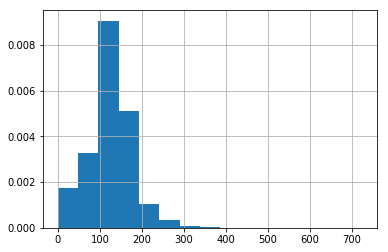

In [95]:
describe_missing('mo_sin_old_il_acct')

We fill missing values in `pct_tl_nvr_dlq` with the rounded mean to one decimal place to match the format of the other values.

In [96]:
X_test['mo_sin_old_il_acct'].fillna(np.round(X_train['mo_sin_old_il_acct'].mean(), 1), inplace=True)
X_train['mo_sin_old_il_acct'].fillna(np.round(X_train['mo_sin_old_il_acct'].mean(), 1), inplace=True)

#### `pct_tl_nvr_dlq`

In [97]:
# find column with most missing values
X_train.count().idxmin()

'pct_tl_nvr_dlq'

0.0853267321731
count    543165.000000
mean         94.398497
std           8.386056
min           6.700000
25%          91.700000
50%          98.100000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64
1    0.847148
0    0.152852
Name: loan_status, dtype: float64


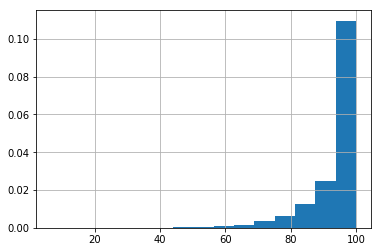

In [98]:
describe_missing('pct_tl_nvr_dlq')

We fill missing values in `pct_tl_nvr_dlq` with the median due to the skew of the data.

In [99]:
X_test['pct_tl_nvr_dlq'].fillna(X_train['pct_tl_nvr_dlq'].median(), inplace=True)
X_train['pct_tl_nvr_dlq'].fillna(X_train['pct_tl_nvr_dlq'].median(), inplace=True)

#### `avg_cur_bal`

In [100]:
# find column with most missing values
X_train.count().idxmin()

'avg_cur_bal'

0.0851667550751
count    543260.000000
mean      13565.595584
std       16336.569798
min           0.000000
25%        3118.000000
50%        7525.000000
75%       18863.000000
max      958084.000000
Name: avg_cur_bal, dtype: float64
1    0.847098
0    0.152902
Name: loan_status, dtype: float64


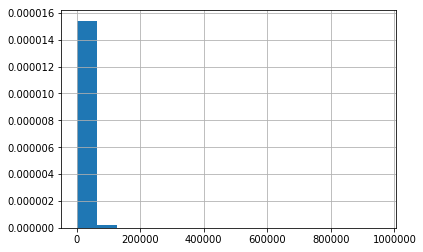

In [101]:
describe_missing('avg_cur_bal')

We fill missing values in `avg_cur_bal` with the median, since the data are highly skewed.

In [102]:
X_test['avg_cur_bal'].fillna(X_train['avg_cur_bal'].median(), inplace=True)
X_train['avg_cur_bal'].fillna(X_train['avg_cur_bal'].median(), inplace=True)

#### `num_rev_accts`

In [103]:
# find column with most missing values
X_train.count().idxmin()

'num_rev_accts'

0.0851499153805
count    543270.000000
mean         15.041589
std           8.107625
min           1.000000
25%           9.000000
50%          14.000000
75%          19.000000
max         112.000000
Name: num_rev_accts, dtype: float64
1    0.847147
0    0.152853
Name: loan_status, dtype: float64


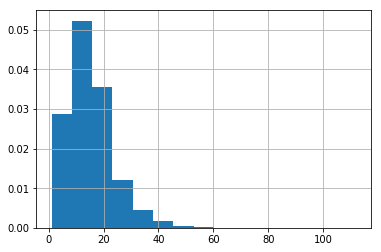

In [104]:
describe_missing('num_rev_accts')

We fill missing values in `mo_sin_old_rev_tl_op` with the median since the data are slightly skewed.

In [107]:
X_test['num_rev_accts'].fillna(X_train['num_rev_accts'].median(), inplace=True)
X_train['num_rev_accts'].fillna(X_train['num_rev_accts'].median(), inplace=True)

#### `mo_sin_old_rev_tl_op`

In [109]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_old_rev_tl_op'

0.0851482314111
count    543271.000000
mean        180.663203
std          91.959833
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tl_op, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


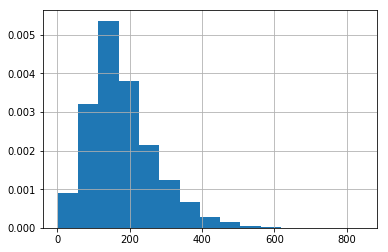

In [110]:
describe_missing('mo_sin_old_rev_tl_op')

We fill missing values in `num_rev_accts` with the median.

In [111]:
X_test['mo_sin_old_rev_tl_op'].fillna(X_train['mo_sin_old_rev_tl_op'].median(), inplace=True)
X_train['mo_sin_old_rev_tl_op'].fillna(X_train['mo_sin_old_rev_tl_op'].median(), inplace=True)

#### `mo_sin_rcnt_rev_tl_op`

In [112]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_rcnt_rev_tl_op'

0.0851482314111
count    543271.000000
mean         12.693067
std          15.597160
min           0.000000
25%           4.000000
50%           8.000000
75%          15.000000
max         372.000000
Name: mo_sin_rcnt_rev_tl_op, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


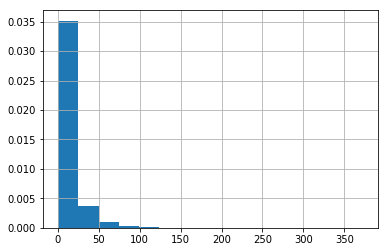

In [113]:
describe_missing('mo_sin_rcnt_rev_tl_op')

We fill missing values in `mo_sin_rcnt_rev_tl_op` with the median.

In [114]:
X_test['mo_sin_rcnt_rev_tl_op'].fillna(X_train['mo_sin_rcnt_rev_tl_op'].median(), inplace=True)
X_train['mo_sin_rcnt_rev_tl_op'].fillna(X_train['mo_sin_rcnt_rev_tl_op'].median(), inplace=True)

#### `mo_sin_rcnt_tl`

In [116]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_rcnt_tl'

0.0851482314111
count    543271.000000
mean          7.690655
std           8.471515
min           0.000000
25%           3.000000
50%           5.000000
75%          10.000000
max         314.000000
Name: mo_sin_rcnt_tl, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


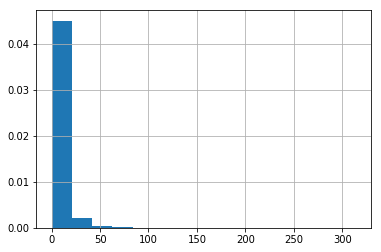

In [117]:
describe_missing('mo_sin_rcnt_tl')

We fill missing values in `mo_sin_rcnt_tl` with the median due to the skew.

In [118]:
X_test['mo_sin_rcnt_tl'].fillna(X_train['mo_sin_rcnt_tl'].median(), inplace=True)
X_train['mo_sin_rcnt_tl'].fillna(X_train['mo_sin_rcnt_tl'].median(), inplace=True)

#### `num_accts_ever_120_pd`

In [121]:
# find column with most missing values
X_train.count().idxmin()

'num_accts_ever_120_pd'

0.0851482314111
count    543271.000000
mean          0.495232
std           1.285155
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          51.000000
Name: num_accts_ever_120_pd, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


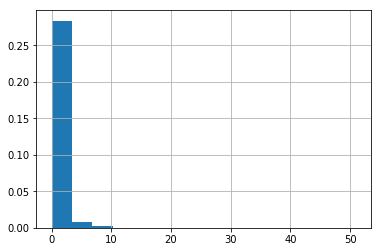

In [122]:
describe_missing('num_accts_ever_120_pd')

We fill missing values in `num_accts_ever_120_pd` with the median due to the skew.

In [123]:
X_test['num_accts_ever_120_pd'].fillna(X_train['num_accts_ever_120_pd'].median(), inplace=True)
X_train['num_accts_ever_120_pd'].fillna(X_train['num_accts_ever_120_pd'].median(), inplace=True)

#### `num_actv_bc_tl`

In [125]:
# find column with most missing values
X_train.count().idxmin()

'num_actv_bc_tl'

0.0851482314111
count    543271.000000
mean          3.632752
std           2.186282
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          33.000000
Name: num_actv_bc_tl, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


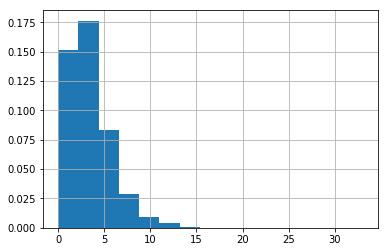

In [126]:
describe_missing('num_actv_bc_tl')

We fill missing values in `num_actv_bc_tl` with the median due to the slight skew and because these values are integers, not floats.

In [127]:
X_test['num_actv_bc_tl'].fillna(X_train['num_actv_bc_tl'].median(), inplace=True)
X_train['num_actv_bc_tl'].fillna(X_train['num_actv_bc_tl'].median(), inplace=True)

#### `num_actv_rev_tl`

In [125]:
# find column with most missing values
X_train.count().idxmin()

'num_actv_rev_tl'

0.0851482314111
count    543271.000000
mean          5.648993
std           3.205252
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          46.000000
Name: num_actv_rev_tl, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


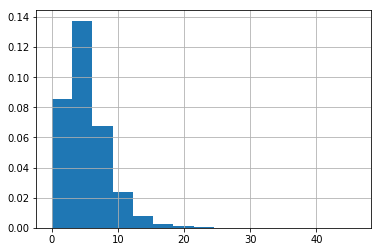

In [129]:
describe_missing('num_actv_rev_tl')

We fill missing values in `num_actv_rev_tl` with the median due to the slight skew and because these are integers, not floats.

In [130]:
X_test['num_actv_rev_tl'].fillna(X_train['num_actv_rev_tl'].median(), inplace=True)
X_train['num_actv_rev_tl'].fillna(X_train['num_actv_rev_tl'].median(), inplace=True)

#### `num_bc_tl`

In [128]:
# find column with most missing values
X_train.count().idxmin()

'num_bc_tl'

0.0851482314111
count    543271.000000
mean          8.433911
std           4.865025
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          68.000000
Name: num_bc_tl, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


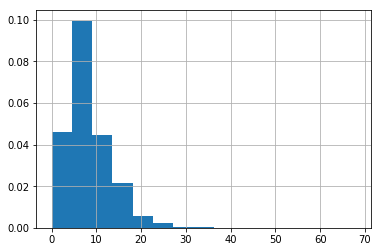

In [132]:
describe_missing('num_bc_tl')

We fill missing values in `num_bc_tl` with the median due to the skew.

In [133]:
X_test['num_bc_tl'].fillna(X_train['num_bc_tl'].median(), inplace=True)
X_train['num_bc_tl'].fillna(X_train['num_bc_tl'].median(), inplace=True)

#### `num_il_tl`

In [131]:
# find column with most missing values
X_train.count().idxmin()

'num_il_tl'

0.0851482314111
count    543271.000000
mean          8.609968
std           7.348478
min           0.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         150.000000
Name: num_il_tl, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


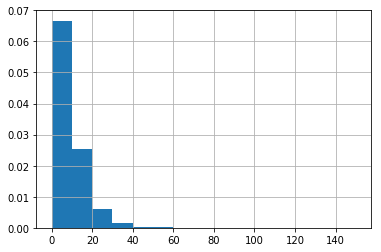

In [135]:
describe_missing('num_il_tl')

We fill missing values in `num_il_tl` with the median due to the slight skew.

In [136]:
X_test['num_il_tl'].fillna(X_train['num_il_tl'].median(), inplace=True)
X_train['num_il_tl'].fillna(X_train['num_il_tl'].median(), inplace=True)

#### `num_op_rev_tl`

In [134]:
# find column with most missing values
X_train.count().idxmin()

'num_op_rev_tl'

0.0851482314111
count    543271.00000
mean          8.28828
std           4.42903
min           0.00000
25%           5.00000
50%           7.00000
75%          10.00000
max          79.00000
Name: num_op_rev_tl, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


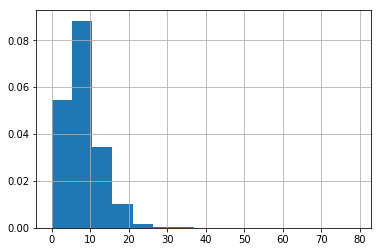

In [138]:
describe_missing('num_op_rev_tl')

We fill missing values in `num_op_rev_tl` with the median due to the skew and due to each value being an integer, not a float.

In [139]:
X_test['num_op_rev_tl'].fillna(X_train['num_op_rev_tl'].median(), inplace=True)
X_train['num_op_rev_tl'].fillna(X_train['num_op_rev_tl'].median(), inplace=True)

#### `num_rev_tl_bal_gt_0`

In [137]:
# find column with most missing values
X_train.count().idxmin()

'num_rev_tl_bal_gt_0'

0.0851482314111
count    543271.000000
mean          5.605957
std           3.138134
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          43.000000
Name: num_rev_tl_bal_gt_0, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


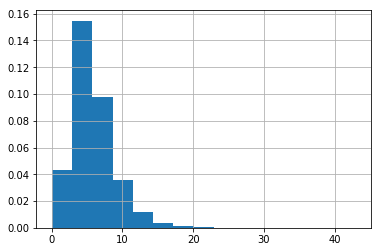

In [141]:
describe_missing('num_rev_tl_bal_gt_0')

We fill missing values in `num_rev_tl_bal_gt_0` with the median (each value is an integer).

In [142]:
X_test['num_rev_tl_bal_gt_0'].fillna(np.round(X_train['num_rev_tl_bal_gt_0'].mean(), 1), inplace=True)
X_train['num_rev_tl_bal_gt_0'].fillna(np.round(X_train['num_rev_tl_bal_gt_0'].mean(), 1), inplace=True)

#### `num_tl_op_past_12m`

In [143]:
# find column with most missing values
X_train.count().idxmin()

'num_tl_op_past_12m'

0.0851482314111
count    543271.000000
mean          2.202260
std           1.824299
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
Name: num_tl_op_past_12m, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


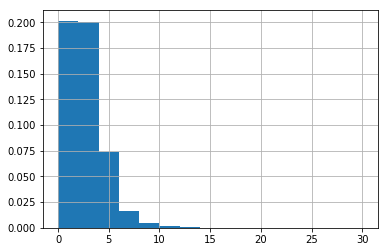

In [144]:
describe_missing('num_tl_op_past_12m')

We fill missing values in `num_tl_op_past_12m` with the median (each value is an integer).

In [145]:
X_test['num_tl_op_past_12m'].fillna(X_train['num_tl_op_past_12m'].median(), inplace=True)
X_train['num_tl_op_past_12m'].fillna(X_train['num_tl_op_past_12m'].median(), inplace=True)

#### `tot_coll_amt`

In [146]:
# find column with most missing values
X_train.count().idxmin()

'tot_coll_amt'

0.0851482314111
count    5.432710e+05
mean     2.353058e+02
std      1.256641e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


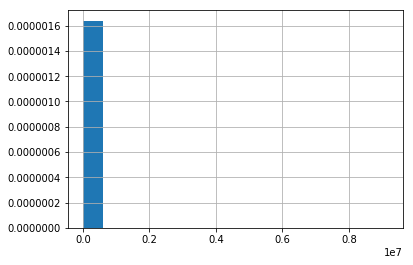

In [147]:
describe_missing('tot_coll_amt')

In [148]:
df['tot_coll_amt'].value_counts(normalize=True).iloc[:10]

0.0      0.855660
50.0     0.002055
100.0    0.001676
75.0     0.001279
200.0    0.000900
150.0    0.000886
60.0     0.000853
80.0     0.000721
70.0     0.000693
65.0     0.000632
Name: tot_coll_amt, dtype: float64

We fill missing values in `tot_coll_amt` with 0.

In [149]:
X_test['tot_coll_amt'].fillna(0, inplace=True)
X_train['tot_coll_amt'].fillna(0, inplace=True)

#### `tot_cur_bal`

In [150]:
# find column with most missing values
X_train.count().idxmin()

'tot_cur_bal'

0.0851482314111
count    5.432710e+05
mean     1.409971e+05
std      1.559456e+05
min      0.000000e+00
25%      2.962500e+04
50%      8.193800e+04
75%      2.106300e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


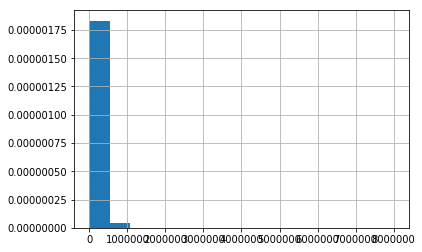

In [151]:
describe_missing('tot_cur_bal')

We fill missing values in `tot_cur_bal` with the median due to the skew.

In [152]:
X_test['tot_cur_bal'].fillna(X_train['tot_cur_bal'].median(), inplace=True)
X_train['tot_cur_bal'].fillna(X_train['tot_cur_bal'].median(), inplace=True)

#### `tot_hi_cred_lim`

In [153]:
# find column with most missing values
X_train.count().idxmin()

'tot_hi_cred_lim'

0.0851482314111
count    5.432710e+05
mean     1.726427e+05
std      1.744743e+05
min      0.000000e+00
25%      4.890000e+04
50%      1.125940e+05
75%      2.500865e+05
max      9.999999e+06
Name: tot_hi_cred_lim, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


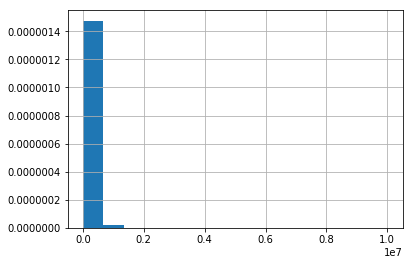

In [154]:
describe_missing('tot_hi_cred_lim')

We fill missing values in `tot_hi_cred_lim` with the median due to the skew.

In [155]:
X_test['tot_hi_cred_lim'].fillna(X_train['tot_hi_cred_lim'].median(), inplace=True)
X_train['tot_hi_cred_lim'].fillna(X_train['tot_hi_cred_lim'].median(), inplace=True)

#### `total_il_high_credit_limit`

In [156]:
# find column with most missing values
X_train.count().idxmin()

'total_il_high_credit_limit'

0.0851482314111
count    5.432710e+05
mean     4.081717e+04
std      4.189834e+04
min      0.000000e+00
25%      1.416400e+04
50%      3.075600e+04
75%      5.497850e+04
max      2.101913e+06
Name: total_il_high_credit_limit, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


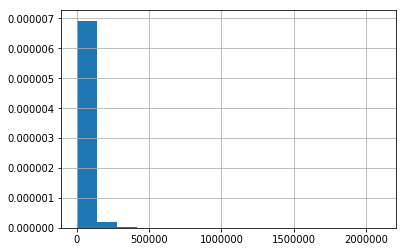

In [157]:
describe_missing('total_il_high_credit_limit')

We fill missing values in `total_il_high_credit_limit` with the median due to the skew.

In [158]:
X_test['total_il_high_credit_limit'].fillna(X_train['total_il_high_credit_limit'].median(), inplace=True)
X_train['total_il_high_credit_limit'].fillna(X_train['total_il_high_credit_limit'].median(), inplace=True)

#### `total_rev_hi_lim`

In [159]:
# find column with most missing values
X_train.count().idxmin()

'total_rev_hi_lim'

0.0851482314111
count    5.432710e+05
mean     3.173122e+04
std      3.734762e+04
min      0.000000e+00
25%      1.380000e+04
50%      2.340000e+04
75%      3.930000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


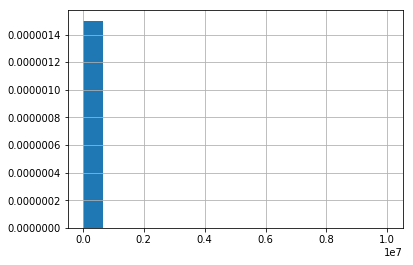

In [160]:
describe_missing('total_rev_hi_lim')

We fill missing values in `total_rev_hi_lim` with the median due to the skew

In [162]:
X_test['total_rev_hi_lim'].fillna(X_train['total_rev_hi_lim'].median(), inplace=True)
X_train['total_rev_hi_lim'].fillna(X_train['total_rev_hi_lim'].median(), inplace=True)

#### `mo_sin_old_rev_tol_op`

In [164]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_old_rev_tol_op'

0.0851482314111
count    543271.000000
mean        180.663203
std          91.959833
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tol_op, dtype: float64
1    0.847144
0    0.152856
Name: loan_status, dtype: float64


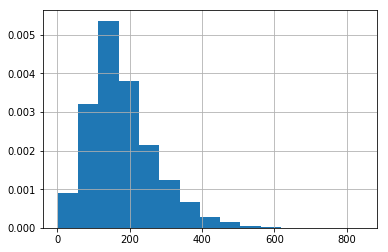

In [165]:
describe_missing('mo_sin_old_rev_tol_op')

We fill missing values in `mo_sin_old_rev_tol_op` with the median, due to the skew.

In [166]:
X_test['mo_sin_old_rev_tol_op'].fillna(X_train['mo_sin_old_rev_tol_op'].median(), inplace=True)
X_train['mo_sin_old_rev_tol_op'].fillna(X_train['mo_sin_old_rev_tol_op'].median(), inplace=True)

#### `num_bc_sats`

In [167]:
# find column with most missing values
X_train.count().idxmin()

'num_bc_sats'

0.0704808574772
count    551981.000000
mean          4.706526
std           2.851655
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          57.000000
Name: num_bc_sats, dtype: float64
1    0.852129
0    0.147871
Name: loan_status, dtype: float64


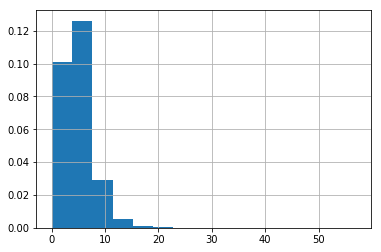

In [168]:
describe_missing('num_bc_sats')

We fill missing values in `num_bc_sats` with the median (each value is an integer).

In [169]:
X_test['num_bc_sats'].fillna(X_train['num_bc_sats'].median(), inplace=True)
X_train['num_bc_sats'].fillna(X_train['num_bc_sats'].median(), inplace=True)

#### `num_sats`

In [170]:
# find column with most missing values
X_train.count().idxmin()

'num_sats'

0.0704808574772
count    551981.000000
mean         11.611059
std           5.330942
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          84.000000
Name: num_sats, dtype: float64
1    0.852129
0    0.147871
Name: loan_status, dtype: float64


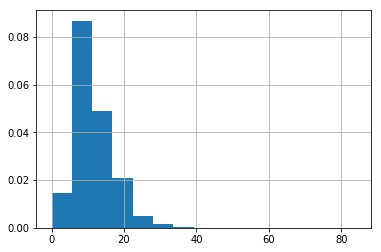

In [171]:
describe_missing('num_sats')

We fill missing values in `num_sats` with the median (each value is an integer).

In [172]:
X_test['num_sats'].fillna(X_train['num_sats'].median(), inplace=True)
X_train['num_sats'].fillna(X_train['num_sats'].median(), inplace=True)

#### `bc_util`

In [173]:
# find column with most missing values
X_train.count().idxmin()

'bc_util'

0.0698965200771
count    552328.000000
mean         61.564135
std          27.900867
min           0.000000
25%          40.700000
50%          65.400000
75%          86.000000
max         339.600000
Name: bc_util, dtype: float64
1    0.843496
0    0.156504
Name: loan_status, dtype: float64


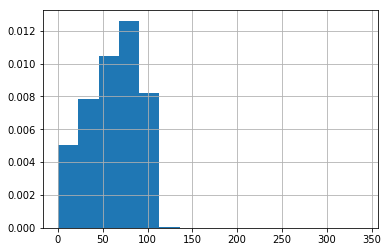

In [174]:
describe_missing('bc_util')

We fill missing values in `bc_util` with the mean (rounded to one decimal).

In [175]:
X_test['bc_util'].fillna(np.round(X_train['bc_util'].mean(), 1), inplace=True)
X_train['bc_util'].fillna(np.round(X_train['bc_util'].mean(), 1), inplace=True)

#### `percent_bc_gt_75`

In [176]:
# find column with most missing values
X_train.count().idxmin()

'percent_bc_gt_75'

0.069687707865
count    552452.000000
mean         47.259191
std          35.647903
min           0.000000
25%          16.700000
50%          50.000000
75%          75.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64
1    0.843583
0    0.156417
Name: loan_status, dtype: float64


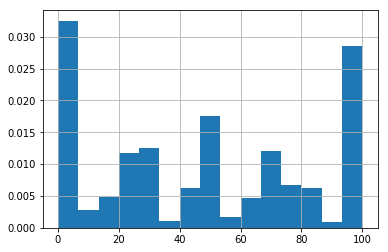

In [177]:
describe_missing('percent_bc_gt_75')

We fill missing values in `percent_bc_gt_75` with the median (the data is evenly spread).

In [178]:
X_test['percent_bc_gt_75'].fillna(X_train['percent_bc_gt_75'].median(), inplace=True)
X_train['percent_bc_gt_75'].fillna(X_train['percent_bc_gt_75'].median(), inplace=True)

#### `bc_open_to_buy`

In [179]:
# find column with most missing values
X_train.count().idxmin()

'bc_open_to_buy'

0.0693189185548
count    552671.000000
mean       9453.475196
std       14535.035882
min           0.000000
25%        1308.000000
50%        4256.000000
75%       11343.000000
max      454843.000000
Name: bc_open_to_buy, dtype: float64
1    0.843917
0    0.156083
Name: loan_status, dtype: float64


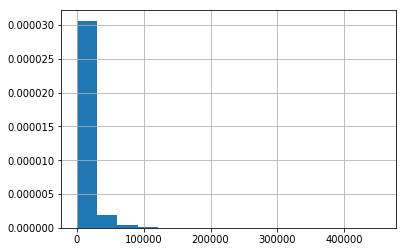

In [180]:
describe_missing('bc_open_to_buy')

We fill missing values in `bc_open_to_buy` with the median due to the skew.

In [181]:
X_test['bc_open_to_buy'].fillna(X_train['bc_open_to_buy'].median(), inplace=True)
X_train['bc_open_to_buy'].fillna(X_train['bc_open_to_buy'].median(), inplace=True)

#### `mths_since_recent_bc`

In [182]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_bc'

0.0685863918429
count    553106.000000
mean         23.353070
std          29.582869
min           0.000000
25%           6.000000
50%          13.000000
75%          28.000000
max         616.000000
Name: mths_since_recent_bc, dtype: float64
1    0.844607
0    0.155393
Name: loan_status, dtype: float64


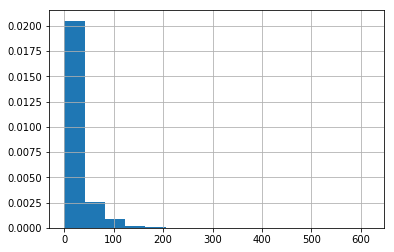

In [183]:
describe_missing('mths_since_recent_bc')

We fill missing values in `mths_since_recent_bc` with the median due to the skew.

In [184]:
X_test['mths_since_recent_bc'].fillna(X_train['mths_since_recent_bc'].median(), inplace=True)
X_train['mths_since_recent_bc'].fillna(X_train['mths_since_recent_bc'].median(), inplace=True)

#### `acc_open_past_24mths`

In [185]:
# find column with most missing values
X_train.count().idxmin()

'acc_open_past_24mths'

0.059646198018
count    558415.000000
mean          4.713161
std           3.147224
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          56.000000
Name: acc_open_past_24mths, dtype: float64
1    0.85432
0    0.14568
Name: loan_status, dtype: float64


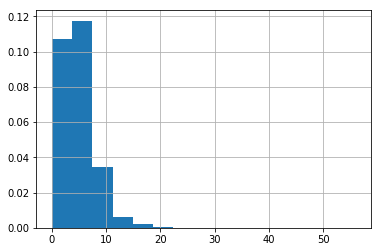

In [186]:
describe_missing('acc_open_past_24mths')

We fill missing values in `acc_open_past_24mths` with the median (each value is an integer).

In [187]:
X_test['acc_open_past_24mths'].fillna(X_train['acc_open_past_24mths'].median(), inplace=True)
X_train['acc_open_past_24mths'].fillna(X_train['acc_open_past_24mths'].median(), inplace=True)

#### `mort_acc`

In [188]:
# find column with most missing values
X_train.count().idxmin()

'mort_acc'

0.059646198018
count    558415.000000
mean          1.764956
std           2.085830
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          37.000000
Name: mort_acc, dtype: float64
1    0.85432
0    0.14568
Name: loan_status, dtype: float64


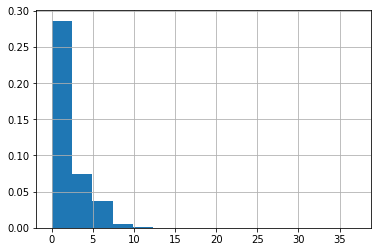

In [189]:
describe_missing('mort_acc')

We fill missing values in `mort_acc` with the median (each value is an integer).

In [190]:
X_test['mort_acc'].fillna(X_train['mort_acc'].median(), inplace=True)
X_train['mort_acc'].fillna(X_train['mort_acc'].median(), inplace=True)

#### `total_bal_ex_mort`

In [191]:
# find column with most missing values
X_train.count().idxmin()

'total_bal_ex_mort'

0.059646198018
count    5.584150e+05
mean     4.853848e+04
std      4.611297e+04
min      0.000000e+00
25%      2.072300e+04
50%      3.668900e+04
75%      6.117650e+04
max      2.688920e+06
Name: total_bal_ex_mort, dtype: float64
1    0.85432
0    0.14568
Name: loan_status, dtype: float64


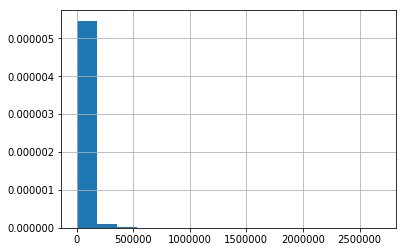

In [192]:
describe_missing('total_bal_ex_mort')

We fill missing values in `total_bal_ex_mort` with the median due to the skew.

In [193]:
X_test['total_bal_ex_mort'].fillna(X_train['total_bal_ex_mort'].median(), inplace=True)
X_train['total_bal_ex_mort'].fillna(X_train['total_bal_ex_mort'].median(), inplace=True)

#### `total_bc_limit`

In [194]:
# find column with most missing values
X_train.count().idxmin()

'total_bc_limit'

0.059646198018
count    558415.000000
mean      20796.412324
std       20645.659188
min           0.000000
25%        7500.000000
50%       14500.000000
75%       27000.000000
max      760000.000000
Name: total_bc_limit, dtype: float64
1    0.85432
0    0.14568
Name: loan_status, dtype: float64


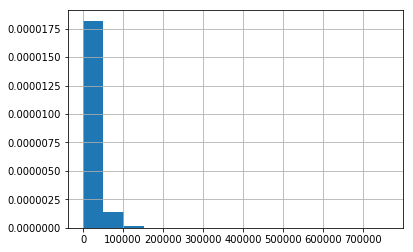

In [195]:
describe_missing('total_bc_limit')

We fill missing values in `total_bc_limit` with the median due to the skew.

In [196]:
X_test['total_bc_limit'].fillna(X_train['total_bc_limit'].median(), inplace=True)
X_train['total_bc_limit'].fillna(X_train['total_bc_limit'].median(), inplace=True)

#### `pub_rec_bankruptcies`

In [197]:
# find column with most missing values
X_train.count().idxmin()

'pub_rec_bankruptcies'

0.000855456482019
count    593327.000000
mean          0.130990
std           0.373787
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: pub_rec_bankruptcies, dtype: float64
1    0.826772
0    0.173228
Name: loan_status, dtype: float64


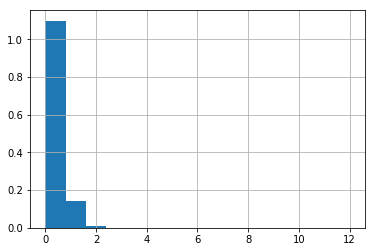

In [198]:
describe_missing('pub_rec_bankruptcies')

We fill missing values in `pub_rec_bankruptcies` with 0.

In [199]:
X_test['pub_rec_bankruptcies'].fillna(0, inplace=True)
X_train['pub_rec_bankruptcies'].fillna(0, inplace=True)

#### `revol_util`

In [200]:
# find column with most missing values
X_train.count().idxmin()

'revol_util'

0.000616332819723
count    593469.000000
mean          0.530175
std           0.243562
min           0.000000
25%           0.350000
50%           0.537000
75%           0.719000
max           8.923000
Name: revol_util, dtype: float64
1    0.775956
0    0.224044
Name: loan_status, dtype: float64


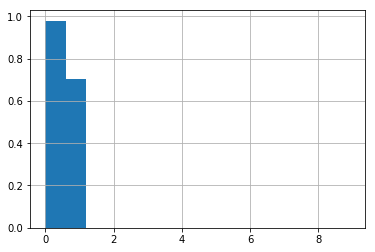

In [201]:
describe_missing('revol_util')

We fill missing values in `revol_util` with the mean.

In [202]:
X_test['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)
X_train['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)

#### `dti`

In [203]:
# find column with most missing values
X_train.count().idxmin()

'dti'

4.04152668671e-05
count    593811.000000
mean         17.836590
std           8.894372
min          -1.000000
25%          11.610000
50%          17.320000
75%          23.580000
max         999.000000
Name: dti, dtype: float64
1    0.833333
0    0.166667
Name: loan_status, dtype: float64


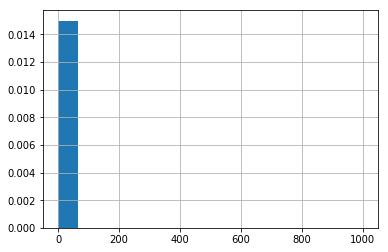

In [196]:
describe_missing('dti')

We fill missing values in `dti` with the median.

In [204]:
X_test['dti'].fillna(X_train['dti'].median(), inplace=True)
X_train['dti'].fillna(X_train['dti'].median(), inplace=True)

Check for any last missing values.

In [206]:
X_train.isnull().any().sum(), X_test.isnull().any().sum()

(0, 1)

In [211]:
X_test.columns[X_test.isnull().any()]

Index(['inq_last_6mths'], dtype='object')

In [212]:
X_test[X_test['inq_last_6mths'].isnull()].index

Int64Index([116175], dtype='int64')

In [213]:
X_test.drop(116175, inplace=True), y_test.drop(116175, inplace=True)

(None, None)

In [215]:
len(X_test), len(y_test)

(197945, 197945)

Save the train and test splits to csv files.

In [216]:
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [219]:
y_train.value_counts(normalize=True)

1    0.796799
0    0.203201
Name: loan_status, dtype: float64

In [220]:
y_test.value_counts(normalize=True)

1    0.797186
0    0.202814
Name: loan_status, dtype: float64